In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

In [5]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


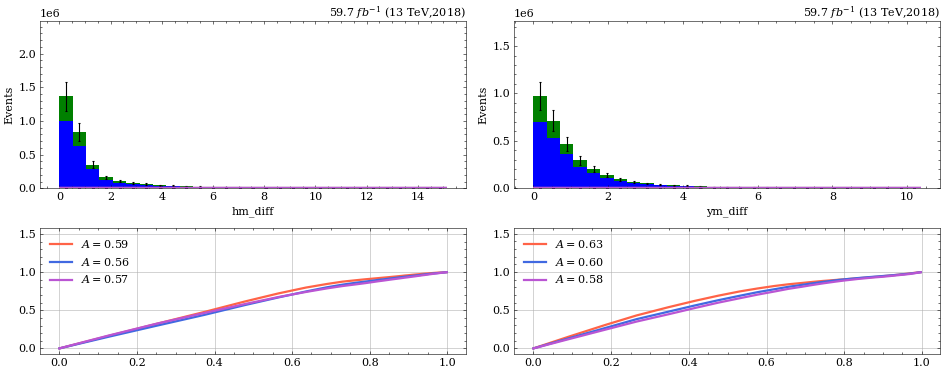

In [13]:
def hm_diff(t):
    hm_diff = (t.H1Y1_m-t.H2Y1_m) + (t.H1Y2_m-t.H2Y2_m)
    hm_diff = hm_diff/125
    t.extend(hm_diff=(hm_diff))
    return (hm_diff)

def ym_diff(t):
    ym_diff = (t.Y1_m) - (t.Y2_m)
    ym_diff = ym_diff/(125)
    t.extend(ym_diff=(ym_diff))
    return (ym_diff)

study.quick(
    signal+bkg,
    transforms=np.abs, 
    varlist=[hm_diff, ym_diff],
    # binlist=[(0,5,30)],

    empirical=True, e_show=False,
    e_correlation=True, e_c_method=None, e_c_label_stat='area'
)


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


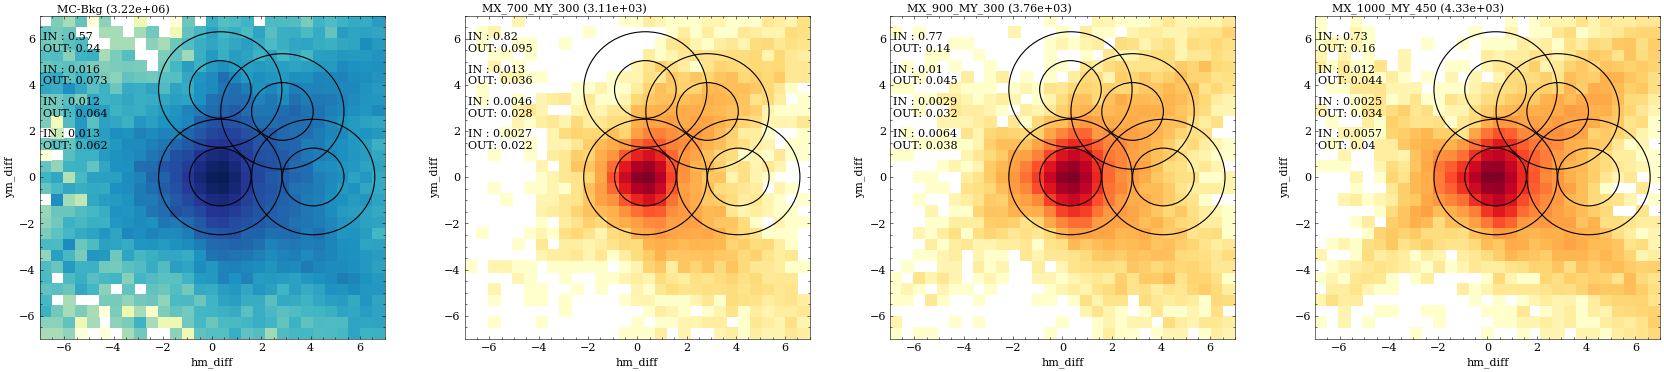

In [14]:
def histo2d_means(ax, histo2d, **kwargs):
    print(histo2d.stats.x_mean, histo2d.stats.y_mean)

centers = [
    (0.33, 0.012),
    (2.85, 2.850),
    (0.33, 3.800),
    (4.10, 0.012),
]

study.quick2d(
    signal+bkg,
    varlist=['hm_diff', 'ym_diff'],
    binlist=[(-7,7,30)]*2,
    exe=[
        draw_concentric(*rs, r1=1.25, r2=2.5, text=(0, 0.95 - 0.1*i))
        for i, rs in enumerate(centers)
    ],
    log=True,
)

100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


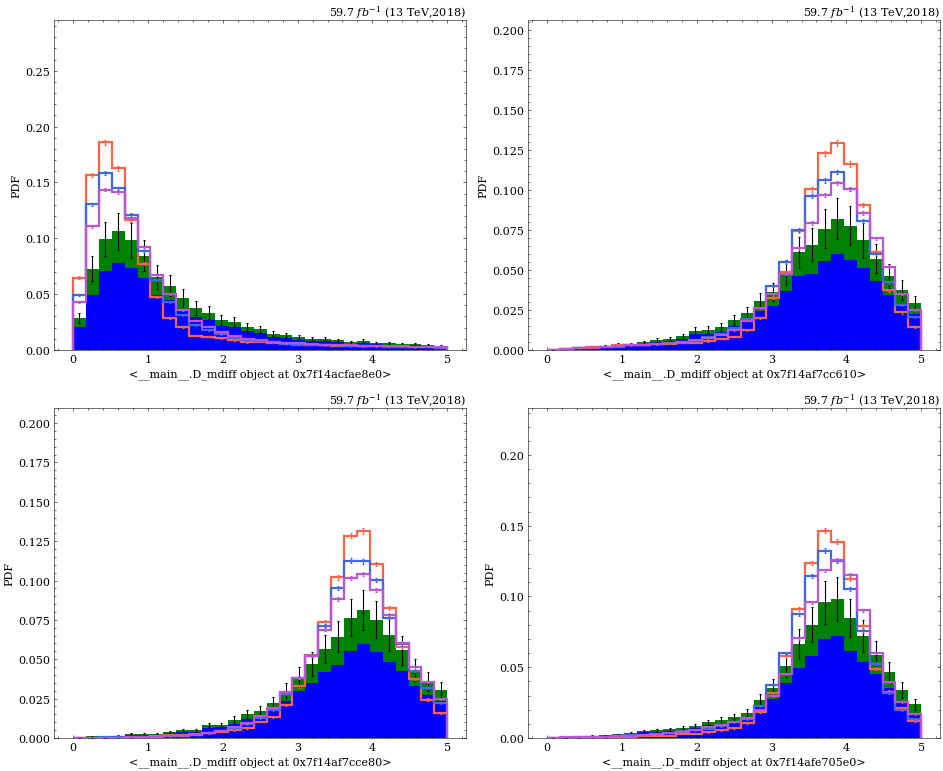

In [15]:
class D_mdiff(ObjTransform):
    def __call__(self, t):
        return np.sqrt( (t.hm_diff-self.rx)**2 + (t.ym_diff-self.ry)**2 )

dm_diffs = [ D_mdiff(rx=rs[0], ry=rs[1]) for rs in centers ]
    
study.quick(
    signal+bkg,
    efficiency=True,
    varlist=dm_diffs,
    binlist=[(0,5,30)]*4,
)

In [23]:
dm_diff = dm_diffs[0]
bdt = ABCD(
    features=['X_m','X_pt'],
    a = lambda t : (t.n_loose_btag >= 4) & (dm_diff(t) < 1.25),
    b = lambda t : (t.n_loose_btag <  4) & (dm_diff(t) < 1.25),
    c = lambda t : (t.n_loose_btag >= 4) & (dm_diff(t) > 1.25) & (dm_diff(t) < 2.5),
    d = lambda t : (t.n_loose_btag <  4) & (dm_diff(t) > 1.25) & (dm_diff(t) < 2.5),
)

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


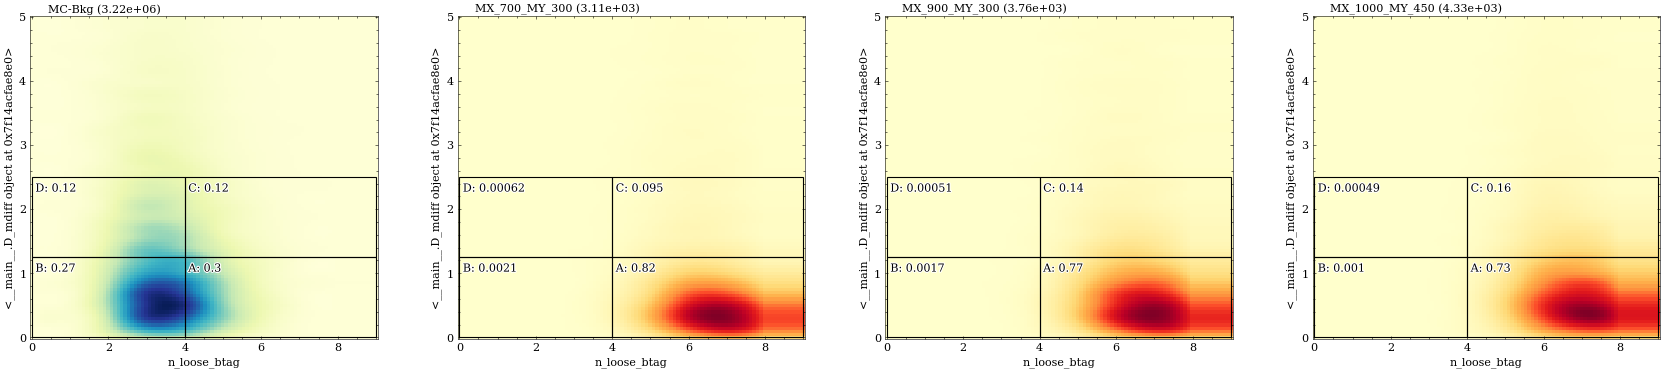

In [24]:
study.quick2d(
    signal+bkg,
    # efficiency=True,
    yvarlist=[dm_diff],
    ybinlist=[(0,5,30)],
    xvarlist=['n_loose_btag'],
    exe=draw_abcd(x_r=(0,4,9),y_r=(0,1.25,2.5), regions=["C","D","A","B"]),
    interp=True,
)

In [25]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 9.648e-01
k*(b/a)-1  = -12.74%
BDT(b)/a-1 = -3.99%



100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


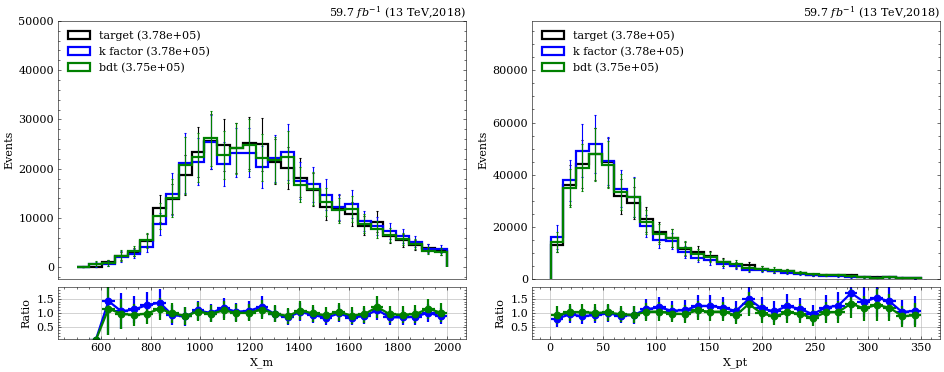

In [26]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,

    ratio=True,
)

100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


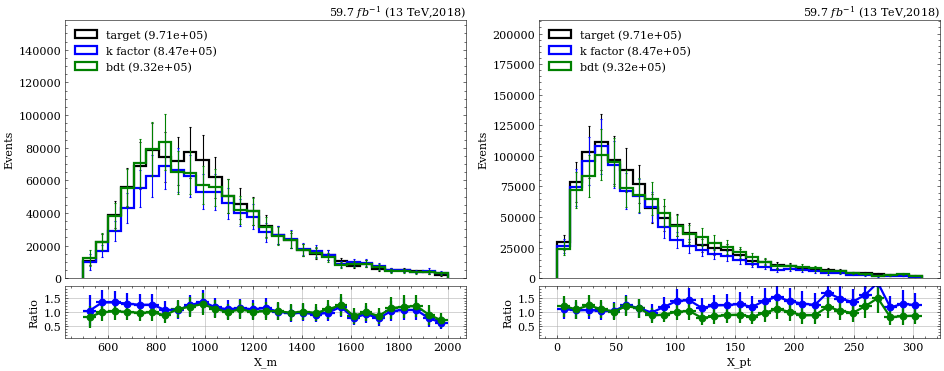

In [27]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,

    ratio=True,
)

100%|██████████| 1/1 [00:26<00:00, 26.33s/it]


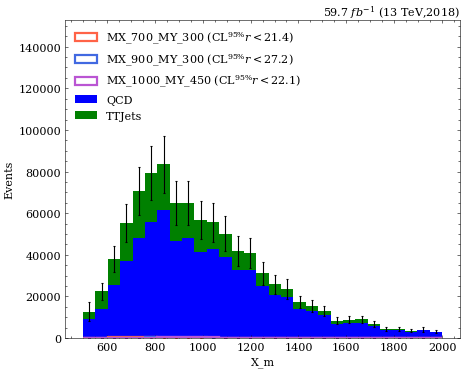

In [28]:
study.quick(
    signal + bkg, 
    legend=True,
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    limits=True,
)